In [1]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [2]:
import numpy as np
import os
import astropy
from astropy import units as u
import matplotlib.pyplot as plt

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore, observatory_locations
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    GaussianSpatialModel
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [3]:
source = 'PKS'
if source == "PKS":
    pks = True
    msh = False
    pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
    pks_pos = SkyCoord("21h58m43.2s", "-30d13m18s")
    dataset_public = MapDataset.read('datasets/dataset-stacked.fits.gz')

    path = 'hess_data/std_fullEnclosure/pks2155_flare/out'
    data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
    observations = data_store.get_observations(data_store.obs_ids)
    dataset_simulated = MapDataset.read('datasets/dataset-simulated-100.0-hr.fits.gz')

    
empty = dataset_public.copy()


In [4]:
try:
    models  = Models.read('models/standard_model.yml')
except:
    st_model = SkyModel(spatial_model = PointSpatialModel(lon_0 = pks_pos.l.deg *u.deg, lat_0 =  pks_pos.b.deg * u.deg),
                       spectral_model = PowerLawSpectralModel())
    Models(st_model).write("models/standard_model.yml")
    models  = Models.read('models/standard_model.yml')
    

In [5]:
dataset_simulated.mask.geom.axes[0].center

<Quantity [ 0.1154782 ,  0.15399265,  0.2053525 ,  0.27384196,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478198,  1.53992653,
            2.05352503,  2.73841963,  3.65174127,  4.86967525,  6.49381632,
            8.65964323, 11.54781985, 15.39926526, 20.53525026, 27.38419634,
           36.51741273, 48.69675252, 64.93816316, 86.59643234] TeV>

In [6]:
emask_edge = dataset_simulated.mask.data.sum(axis=2).sum(axis=1) >0
emask_edge = dataset_simulated.mask.geom.axes[0].center[emask_edge]


In [7]:
emask = dataset_simulated.mask.data.sum(axis=2).sum(axis=1) >0
emask = dataset_simulated.mask.geom.axes[0].center[emask]
dataset_simulated.mask.data.sum(axis=2).sum(axis=1)

array([    0,     0,     0,     0, 44529, 47260, 47260, 47260, 47260,
       47260, 47260, 47260, 47260, 47260, 47260, 47260, 47260, 47260,
       47260, 47260, 47260, 47260, 47260, 47260])

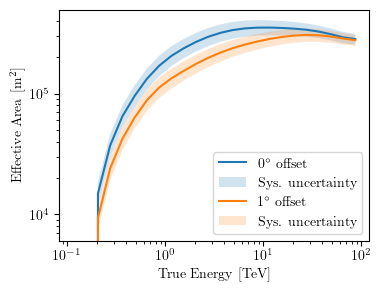

In [8]:
eff_area =  dataset_simulated.exposure.copy()
eff_area /= (100 *u.hr).to(u.s)

#eff_area.cutout(dataset_simulated.exposure.geom.center_skydir, 5*u.deg).sum_over_axes().plot(add_cbar = 1);


etrue = eff_area.geom.axes[0].center



from gammapy.modeling.models import PowerLawNormSpectralModel
pl  =PowerLawNormSpectralModel(reference = 100 *u.TeV, tilt = 0.02, norm = 1.1)
pl_neg  =PowerLawNormSpectralModel(reference = 100 *u.TeV, tilt = -0.02, norm = 0.9)
pl(etrue)


fig, ax = plt.subplots(1,1, figsize = (4,3))


zero = eff_area.data[:, 250:251,250:251]
plt.plot(etrue, zero.flatten(), label = "0$^\circ$ offset")
plt.fill_between(etrue.value, zero.flatten() * pl_neg(etrue), zero.flatten() * pl(etrue), alpha=0.2,
                label = "Sys. uncertainty")

one = eff_area.data[:, 300:301,300:301]
plt.plot(etrue, one.flatten(),label = "1$^\circ$ offset")
plt.fill_between(etrue.value, one.flatten() * pl_neg(etrue), one.flatten() * pl(etrue), alpha=0.2,
                label = "Sys. uncertainty")
plt.loglog()
plt.legend()

ax.set_xlabel("True Energy [TeV]")
ax.set_ylabel("Effective Area [m$^2$]")
fig.savefig("plots/3-exposure_Etrue_function.pdf", bbox_inches = 'tight')



## IRF plots

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(


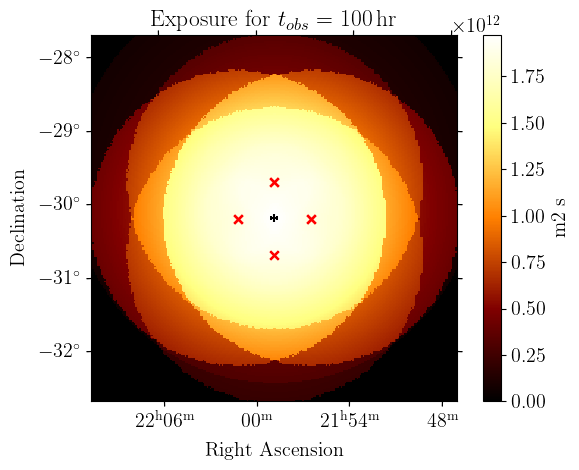

In [9]:
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)

ra_pnt, dec_pnt = [], []
for obs in observations:
    ra_pnt.append(obs.obs_info['RA_PNT'])
    dec_pnt.append(obs.obs_info['DEC_PNT'])
    


fig = plt.figure( )
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
dataset_simulated.exposure.cutout(dataset_simulated.exposure.geom.center_skydir, 5*u.deg).sum_over_axes().plot(add_cbar = 1);

ax = plt.gca()
fig = plt.gcf()
ax.set_title("Exposure for $t_{obs}$ $ = 100\,$hr", fontsize = 17)
for i in range(len(observations)):
    ax.scatter(ra_pnt[i], dec_pnt[i], marker = 'x', color ='red',
              transform=plt.gca().get_transform("icrs"))
plt.scatter(obs.obs_info['RA_OBJ'], obs.obs_info['DEC_OBJ'] , marker = '+',  color = 'black',
            transform=plt.gca().get_transform("icrs"))
    
plt.tight_layout()
fig.savefig("plots/3-exposure.pdf")
fig.savefig("plots/3-exposure.svg")
fig.savefig("plots/3-exposure.png")

In [10]:
dataset_simulated.psf.containment_radius(0.68, 1*u.TeV)

<Quantity [0.09825] deg>

In [11]:
dataset_simulated.psf

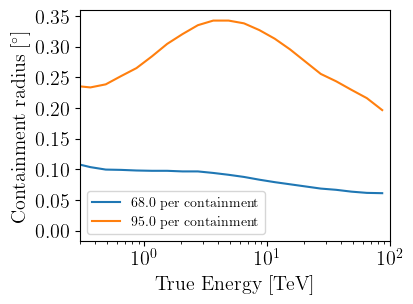

In [12]:
fig ,ax = plt.subplots(1,1, figsize = (4,3))
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
dataset_simulated.psf.plot_containment_radius_vs_energy( ax = ax )
ax.set_xlim(0.3, 100)
fig.savefig("plots/3-psf.pdf", bbox_inches = 'tight')
fig.savefig("plots/3-psf.svg", bbox_inches = 'tight')
fig.savefig("plots/3-psf.png", bbox_inches = 'tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


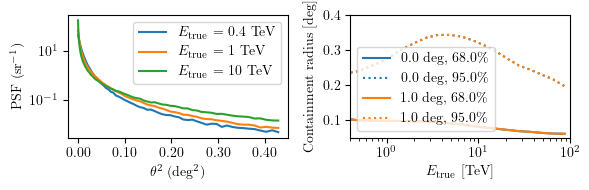

In [13]:

from astropy.visualization import quantity_support
from matplotlib.ticker import FormatStrFormatter
def plot_psf_vs_rad(psf, ax=None, energy_true=[0.4, 1, 10] * u.TeV, **kwargs):
        """Plot PSF vs radius.

        The method plots the profile at the center of the map.

        Parameters
        ----------
        ax : `~matplotlib.pyplot.Axes`
            Axes to plot on.
        energy : `~astropy.units.Quantity`
            Energies where to plot the PSF.
        **kwargs : dict
            Keyword arguments pass to `~matplotlib.pyplot.plot`.

        Returns
        -------
        ax : `~matplotlib.pyplot.Axes`
             Axes to plot on.

        """
        ax = plt.gca() if ax is None else ax

        rad = psf.psf_map.geom.axes["rad"].center

        for value in energy_true:
            psf_value = psf.psf_map.interp_by_coord(
                {
                    "skycoord": psf.psf_map.geom.center_skydir,
                    psf.energy_name: value,
                    "rad": rad,
                }
            )
            label =  r"$E_{\mathrm{true}}$ = " + f"{int(value.value)} TeV"

            if value.value<1:
                label =   r"$E_{\mathrm{true}}$ = " + f"{value:.3}"
            with quantity_support():
                ax.plot(rad **2 , psf_value, label=label, **kwargs)

        ax.set_yscale("log")
        ax.set_xlabel(f"$\\theta ^2$ (deg$^2$)")
        ax.set_ylabel(f"PSF (sr$^{{-1}}$)")
        ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
        plt.legend()
        return ax
    
    
fig, (ax2, ax) = plt.subplots(1,2, figsize= (6,2))
plot_psf_vs_rad(dataset_simulated.psf,ax = ax2)
ax2.legend()


psf= dataset_simulated.psf
energy_axis = psf.psf_map.geom.axes[psf.energy_name]
energy_true = energy_axis.center
fraction = [0.68,0.95]
ls = ['-', ':']
position = psf.psf_map.geom.center_skydir

for i, frac in enumerate(fraction):
    radius = psf.containment_radius(frac, energy_true, position)
    label = f"0.0 deg, {100 * frac:.1f}\%"
    ax.plot(energy_true, radius, label=label,
                color = 'tab:blue', linestyle =ls[i])
offset = SkyCoord(position.ra, position.dec + 1*u.deg)  
for i, frac in enumerate(fraction):
    radius = psf.containment_radius(frac, energy_true, position)
    label = f"1.0 deg, {100 * frac:.1f}\%"
    ax.plot(energy_true, radius, label=label,
                color = 'tab:orange', linestyle =ls[i])

ax.set_xlabel(f"$E_\\mathrm{{true}}$ [TeV]")
ax.set_ylabel(f"Containment radius [deg]")
ax.legend(loc = 'lower left')
ax.set_xlim(0.4, 100)
ax.set_ylim(0.05, 0.4)
ax.set_xscale("log")
plt.tight_layout()
fig.savefig("plots/3-psf.pdf", bbox_inches = "tight")

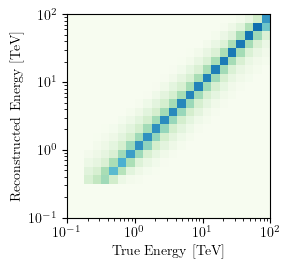

In [14]:
fig, ax = plt.subplots(1,1, figsize= (3,3))
edisp = dataset_simulated.edisp.get_edisp_kernel()
edisp.plot_matrix(ax =ax)
ax.set_ylabel("Reconstructed Energy [TeV]")
plt.tight_layout()
ax.set_aspect("equal")

fig.savefig("plots/3-edisp.pdf")
fig.savefig("plots/3-edisp.svg")
fig.savefig("plots/3-edisp.png")

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


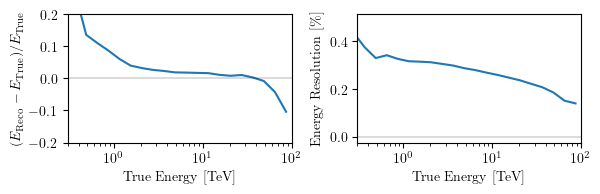

In [15]:
fig, (ax2, ax) = plt.subplots(1,2, figsize= (6,2))
res = dataset_simulated.edisp.get_edisp_kernel().get_resolution(energy_true= dataset_simulated.edisp.get_edisp_kernel().axes[0].center)
ax.plot(dataset_simulated.edisp.get_edisp_kernel().axes[0].center.value, res)
ax.set_xlabel("True Energy [TeV]")
ax.set_ylabel("Energy Resolution [$\%$]")

plt.tight_layout()
ax.set_xlim(0.3,100)
ax.set_xscale('log')
ax.hlines(0., 0.3, 100, color=  'black', lw = 0.2)
#ax.set_ylim(-0.2, 0.2)

dataset_simulated.edisp.get_edisp_kernel().plot_bias(ax =ax2)
ax2.set_xlabel("True Energy [TeV]")
plt.tight_layout()
ax2.set_xlim(0.3,100)
ax2.hlines(0., 0.3, 100, color=  'black', lw = 0.2)
ax2.set_ylim(-0.2, 0.2)


fig.savefig("plots/3-res.pdf")
fig.savefig("plots/3-res.svg")
fig.savefig("plots/3-res.png")
